Installing dependencies. You might need to tweak the CMAKE_ARGS for the `llama-cpp-python` pip package.

In [ ]:
# GPU llama-cpp-python; Starting from version llama-cpp-python==0.1.79, it supports GGUF
!CMAKE_ARGS="-DLLAMA_CUBLAS=on " pip install 'llama-cpp-python>=0.1.79' --force-reinstall --upgrade --no-cache-dir
# For download the models
!pip install huggingface_hub
!pip install datasets

We start by downloading an instruction-finetuned Mistral model, which we will ask to classify model outputs for us.

# Exploratory Data Analysis (EDA)

We'll analyze the SHROOM dataset to understand:
- Dataset size and structure
- Class distribution (Hallucination vs Not Hallucination)
- Task breakdown (DM, MT, PG)
- Text statistics (length, overlap, etc.)
- Sample examples

In [ ]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from pathlib import Path

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)


## 1. Load Datasets

We'll load the train, validation, and test datasets to analyze their structure and contents.

In [ ]:
train_path = "/Users/fatemehizadinejad/Downloads/NLP-ProjectWork/SHROOM_unlabeled-training-data-v2/train.model-aware.v2.json"
val_path = "/Users/fatemehizadinejad/Downloads/NLP-ProjectWork/data/val.model-aware.v2.json"
test_path = "/Users/fatemehizadinejad/Downloads/NLP-ProjectWork/SHROOM_test-labeled/test.model-aware.json"

def load_json_data(file_path):
    """Load JSON data and return as list of dictionaries"""
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            data = json.load(f)
        print(f"✓ Loaded {len(data)} examples from {Path(file_path).name}")
        return data
    except FileNotFoundError:
        print(f"✗ File not found: {file_path}")
        return None
    except Exception as e:
        print(f"✗ Error loading {file_path}: {e}")
        return None

train_data = load_json_data(train_path)
val_data = load_json_data(val_path)
test_data = load_json_data(test_path)

datasets = {
    'Train (unlabeled)': train_data,
    'Validation': val_data,
    'Test': test_data
}

print("\n" + "="*60)
print("DATASET SUMMARY")
print("="*60)
for name, data in datasets.items():
    if data:
        print(f"{name:20s}: {len(data):6,} examples")
print("="*60)

✓ Loaded 30000 examples from train.model-aware.v2.json
✓ Loaded 501 examples from val.model-aware.v2.json
✓ Loaded 1500 examples from test.model-aware.json

DATASET SUMMARY
Train (unlabeled)   : 30,000 examples
Validation          :    501 examples
Test                :  1,500 examples


## 2. Inspect Data Structure

Let's look at a few examples to understand the data format and fields.

In [ ]:
if test_data:
    print("EXAMPLE FROM TEST SET (labeled):")
    print("="*60)
    example = test_data[0]
    for key, value in example.items():
        if isinstance(value, str) and len(value) > 100:
            print(f"{key:15s}: {value[:100]}...")
        else:
            print(f"{key:15s}: {value}")
    print()

if train_data:
    print("EXAMPLE FROM TRAIN SET (unlabeled):")
    print("="*60)
    example = train_data[0]
    for key, value in example.items():
        if isinstance(value, str) and len(value) > 100:
            print(f"{key:15s}: {value[:100]}...")
        else:
            print(f"{key:15s}: {value}")
    print()

if test_data:
    print(f"\nFields in labeled data: {list(test_data[0].keys())}")
if train_data:
    print(f"Fields in unlabeled data: {list(train_data[0].keys())}")

EXAMPLE FROM TEST SET (labeled):
id             : 0
src            : Sadly , at the end of his life , Luther became somewhat of a nutso .
tgt            : Crazy person ; crackpot or lunatic .
hyp            : A crazy person .
task           : DM
labels         : ['Not Hallucination', 'Not Hallucination', 'Not Hallucination', 'Not Hallucination', 'Not Hallucination']
label          : Not Hallucination
p(Hallucination): 0.0

EXAMPLE FROM TRAIN SET (unlabeled):
hyp            : Of or pertaining to the language of a particular area , or to a particular
tgt            : Of or pertaining to everyday language , as opposed to standard , literary , liturgical , or scientif...
src            : There are blacktips , silvertips , bronze whalers , black whalers , spinner sharks , and bignose sha...
ref            : tgt
task           : DM
model          : ltg/flan-t5-definition-en-base


Fields in labeled data: ['id', 'src', 'tgt', 'hyp', 'task', 'labels', 'label', 'p(Hallucination)']
Fields in unl

## 3. Class Distribution Analysis

Let's analyze the distribution of Hallucination vs Not Hallucination labels (for labeled datasets).


VALIDATION - Class Distribution:
  Not Hallucination   :   295 (58.88%)
  Hallucination       :   206 (41.12%)
  TOTAL               :   501
  Imbalance ratio: 1.43:1

TEST - Class Distribution:
  Not Hallucination   :   949 (63.27%)
  Hallucination       :   551 (36.73%)
  TOTAL               : 1,500
  Imbalance ratio: 1.72:1


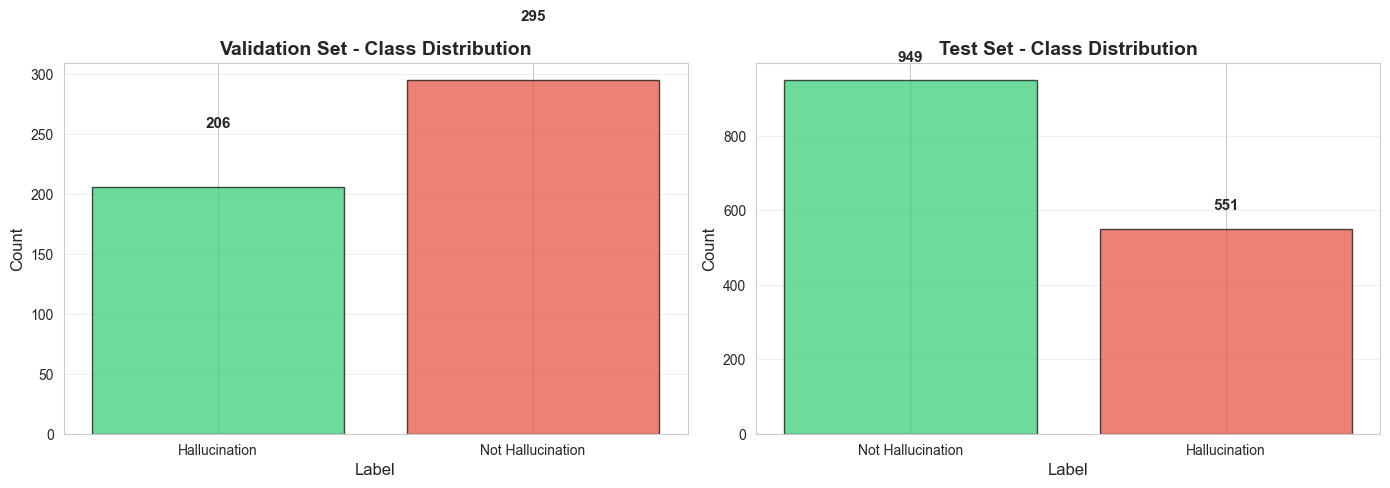

In [ ]:
def analyze_class_distribution(data, dataset_name):
    """Analyze and visualize class distribution"""
    if not data or 'label' not in data[0]:
        print(f"{dataset_name}: No labels available (unlabeled dataset)")
        return None
    
    labels = [item['label'] for item in data]
    label_counts = Counter(labels)
    
    print(f"\n{dataset_name} - Class Distribution:")
    print("="*60)
    total = len(labels)
    for label, count in label_counts.most_common():
        percentage = (count / total) * 100
        print(f"  {label:20s}: {count:5,} ({percentage:5.2f}%)")
    print(f"  {'TOTAL':20s}: {total:5,}")
    
    if len(label_counts) == 2:
        majority = max(label_counts.values())
        minority = min(label_counts.values())
        imbalance_ratio = majority / minority
        print(f"  Imbalance ratio: {imbalance_ratio:.2f}:1")
    
    return label_counts

val_dist = analyze_class_distribution(val_data, "VALIDATION")
test_dist = analyze_class_distribution(test_data, "TEST")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for idx, (data, name, dist) in enumerate([(val_data, 'Validation', val_dist), 
                                            (test_data, 'Test', test_dist)]):
    if dist:
        labels = list(dist.keys())
        counts = list(dist.values())
        colors = ['#2ecc71', '#e74c3c'] 
        
        axes[idx].bar(labels, counts, color=colors, alpha=0.7, edgecolor='black')
        axes[idx].set_title(f'{name} Set - Class Distribution', fontsize=14, fontweight='bold')
        axes[idx].set_ylabel('Count', fontsize=12)
        axes[idx].set_xlabel('Label', fontsize=12)
        
        for i, (label, count) in enumerate(zip(labels, counts)):
            axes[idx].text(i, count + 50, f'{count:,}', ha='center', fontsize=11, fontweight='bold')
        
        axes[idx].grid(axis='y', alpha=0.3)
    else:
        axes[idx].text(0.5, 0.5, 'No labels available', 
                      ha='center', va='center', transform=axes[idx].transAxes, fontsize=14)
        axes[idx].set_title(f'{name} Set', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

## 4. Task Type Distribution

Analyze how examples are distributed across different NLG tasks (DM, MT, PG).


TRAIN - Task Distribution:
  DM   : 10,000 (33.33%)
  PG   : 10,000 (33.33%)
  MT   : 10,000 (33.33%)

VALIDATION - Task Distribution:
  DM   :   188 (37.52%)
  MT   :   188 (37.52%)
  PG   :   125 (24.95%)

VALIDATION - Task × Label Breakdown:
Task         Hallucination   Not Hallucinati     Total
------------------------------------------------------------
DM                      89                99       188
MT                      91                97       188
PG                      26                99       125

TEST - Task Distribution:
  MT   :   563 (37.53%)
  DM   :   562 (37.47%)
  PG   :   375 (25.00%)

TEST - Task × Label Breakdown:
Task         Hallucination   Not Hallucinati     Total
------------------------------------------------------------
DM                     268               294       562
MT                     214               349       563
PG                      69               306       375


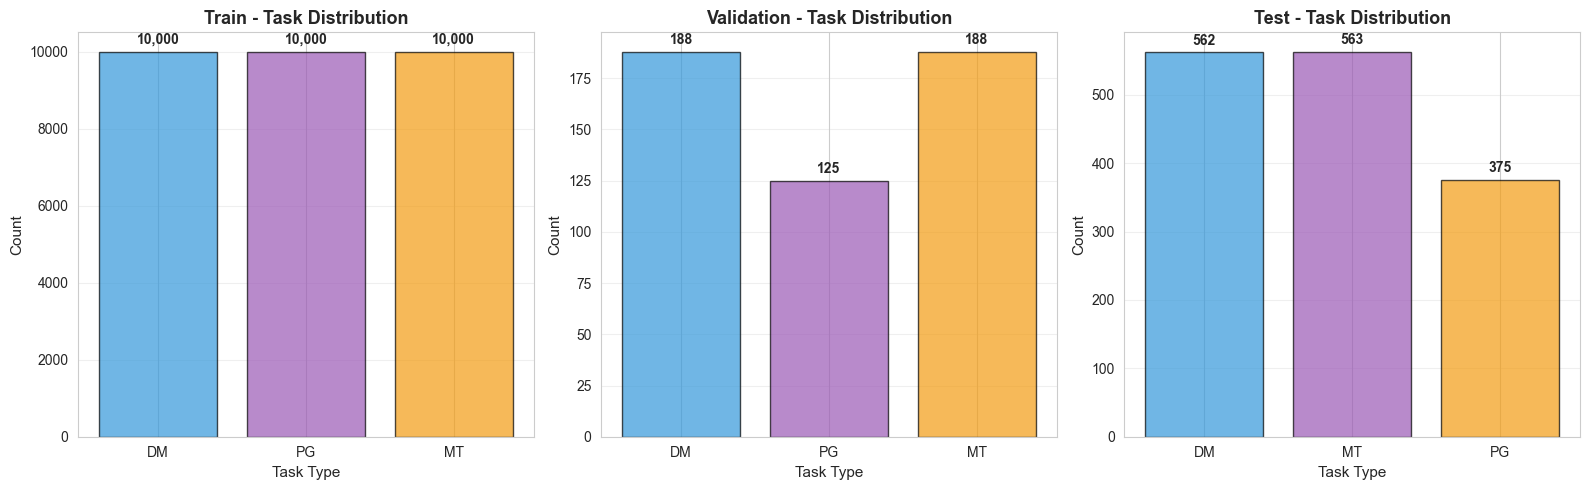

In [ ]:
def analyze_task_distribution(data, dataset_name):
    """Analyze distribution across tasks and labels"""
    if not data:
        return None
    
    tasks = [item['task'] for item in data]
    task_counts = Counter(tasks)
    
    print(f"\n{dataset_name} - Task Distribution:")
    print("="*60)
    total = len(tasks)
    for task, count in task_counts.most_common():
        percentage = (count / total) * 100
        print(f"  {task:5s}: {count:5,} ({percentage:5.2f}%)")
    
    if 'label' in data[0]:
        print(f"\n{dataset_name} - Task × Label Breakdown:")
        print("="*60)
        task_label_counts = {}
        for item in data:
            task = item['task']
            label = item['label']
            key = (task, label)
            task_label_counts[key] = task_label_counts.get(key, 0) + 1
        
        tasks_list = sorted(set(t for t, _ in task_label_counts.keys()))
        labels_list = sorted(set(l for _, l in task_label_counts.keys()))
        
        print(f"{'Task':8s}", end='')
        for label in labels_list:
            print(f"{label[:15]:>18s}", end='')
        print(f"{'Total':>10s}")
        print("-" * 60)
        
        for task in tasks_list:
            print(f"{task:8s}", end='')
            row_total = 0
            for label in labels_list:
                count = task_label_counts.get((task, label), 0)
                row_total += count
                print(f"{count:18,}", end='')
            print(f"{row_total:10,}")
    
    return task_counts

train_tasks = analyze_task_distribution(train_data, "TRAIN")
val_tasks = analyze_task_distribution(val_data, "VALIDATION")
test_tasks = analyze_task_distribution(test_data, "TEST")

fig, axes = plt.subplots(1, 3, figsize=(16, 5))
datasets_info = [
    (train_data, 'Train', train_tasks),
    (val_data, 'Validation', val_tasks),
    (test_data, 'Test', test_tasks)
]

for idx, (data, name, task_dist) in enumerate(datasets_info):
    if task_dist:
        tasks = list(task_dist.keys())
        counts = list(task_dist.values())
        colors = ['#3498db', '#9b59b6', '#f39c12']
        
        axes[idx].bar(tasks, counts, color=colors, alpha=0.7, edgecolor='black')
        axes[idx].set_title(f'{name} - Task Distribution', fontsize=13, fontweight='bold')
        axes[idx].set_ylabel('Count', fontsize=11)
        axes[idx].set_xlabel('Task Type', fontsize=11)
        
        for i, (task, count) in enumerate(zip(tasks, counts)):
            axes[idx].text(i, count + max(counts)*0.02, f'{count:,}', 
                          ha='center', fontsize=10, fontweight='bold')
        
        axes[idx].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Text Length Analysis

Analyze the length distribution of source, target, and hypothesis texts.


TEST - Text Length Statistics (in words):
Field            Mean   Median    Min    Max      Std
----------------------------------------------------------------------
Source           17.7     15.0      1    112     12.3
Target           11.7     11.0      0     68     10.1
Hypothesis       13.0     11.0      1     58      7.8


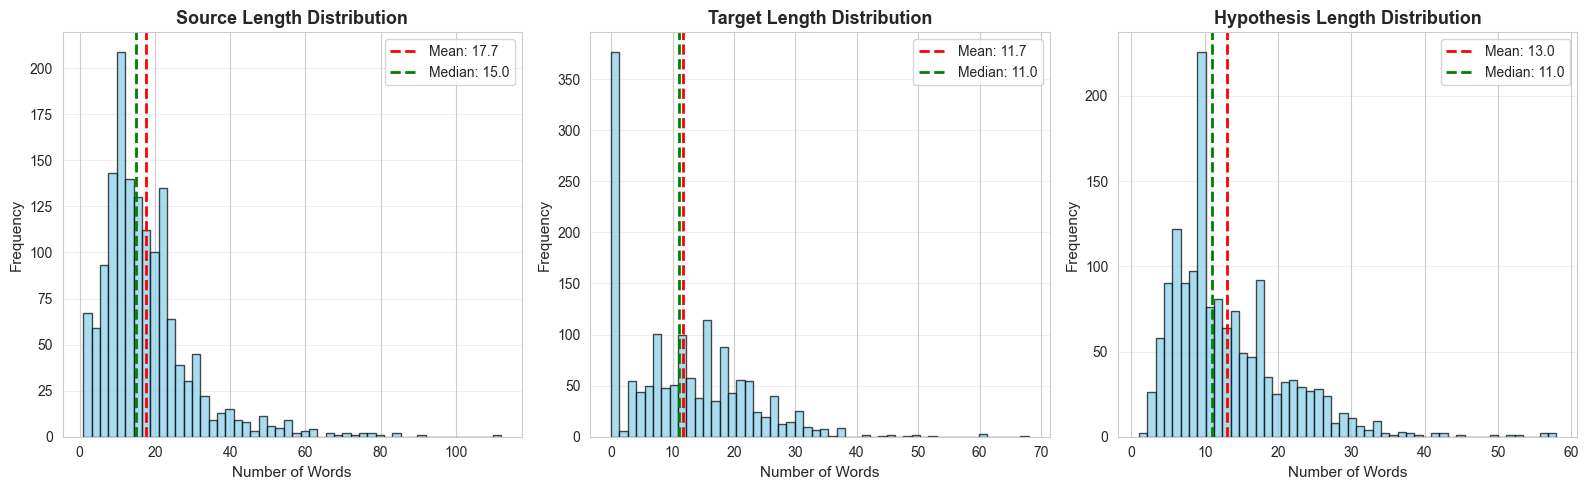

In [ ]:
def compute_text_stats(data, dataset_name):
    """Compute statistics about text lengths"""
    if not data:
        return None
    
    src_lengths = [len(item['src'].split()) for item in data]
    tgt_lengths = [len(item['tgt'].split()) for item in data]
    hyp_lengths = [len(item['hyp'].split()) for item in data]
    
    stats = {
        'Source': src_lengths,
        'Target': tgt_lengths,
        'Hypothesis': hyp_lengths
    }
    
    print(f"\n{dataset_name} - Text Length Statistics (in words):")
    print("="*70)
    print(f"{'Field':12s} {'Mean':>8s} {'Median':>8s} {'Min':>6s} {'Max':>6s} {'Std':>8s}")
    print("-"*70)
    
    for field, lengths in stats.items():
        mean = np.mean(lengths)
        median = np.median(lengths)
        min_len = np.min(lengths)
        max_len = np.max(lengths)
        std = np.std(lengths)
        print(f"{field:12s} {mean:8.1f} {median:8.1f} {min_len:6.0f} {max_len:6.0f} {std:8.1f}")
    
    return stats

test_stats = compute_text_stats(test_data, "TEST")

if test_stats:
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    
    for idx, (field, lengths) in enumerate(test_stats.items()):
        axes[idx].hist(lengths, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
        axes[idx].axvline(np.mean(lengths), color='red', linestyle='--', 
                         linewidth=2, label=f'Mean: {np.mean(lengths):.1f}')
        axes[idx].axvline(np.median(lengths), color='green', linestyle='--', 
                         linewidth=2, label=f'Median: {np.median(lengths):.1f}')
        axes[idx].set_title(f'{field} Length Distribution', fontsize=13, fontweight='bold')
        axes[idx].set_xlabel('Number of Words', fontsize=11)
        axes[idx].set_ylabel('Frequency', fontsize=11)
        axes[idx].legend()
        axes[idx].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## 6. Text Overlap Analysis

Compute overlap metrics between source/target and hypothesis to identify patterns in hallucinations.

Computing overlap metrics for TEST set...

Word Overlap Statistics (Jaccard Similarity):
Category                      Mean   Median      Std
------------------------------------------------------------
Hallucination                0.255    0.231    0.146
Not Hallucination            0.360    0.345    0.173


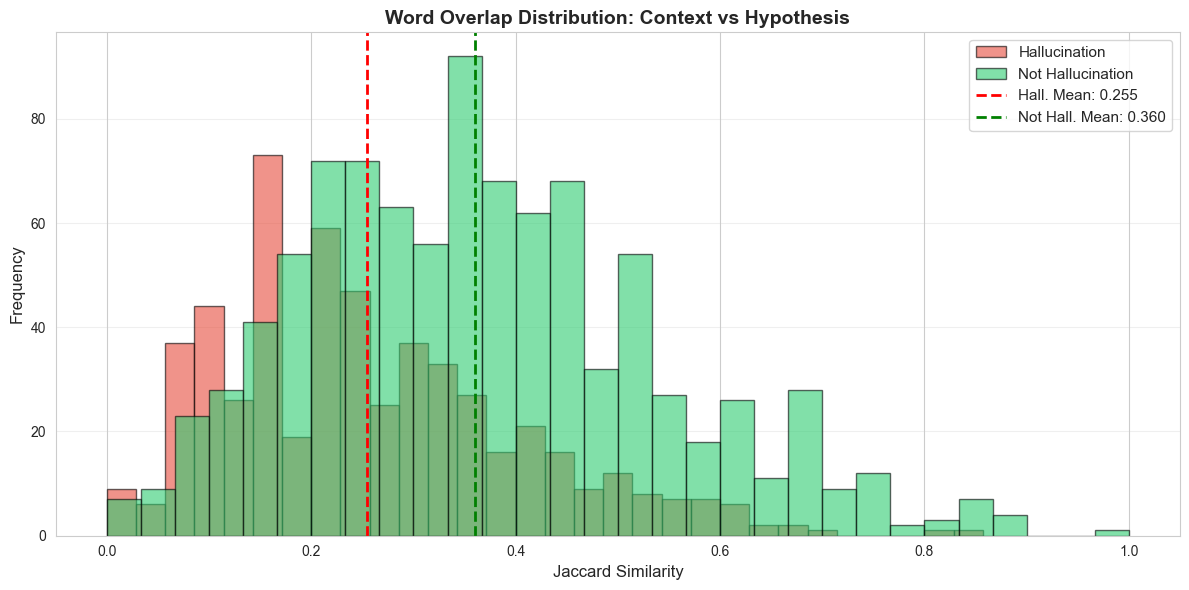

In [ ]:
def compute_word_overlap(text1, text2):
    words1 = set(text1.lower().split())
    words2 = set(text2.lower().split())
    
    if not words1 or not words2:
        return 0.0
    
    intersection = words1.intersection(words2)
    union = words1.union(words2)
    
    return len(intersection) / len(union) if union else 0.0

def compute_char_overlap(text1, text2):
    if not text1 or not text2:
        return 0.0
    
    chars1 = set(text1.lower())
    chars2 = set(text2.lower())
    intersection = chars1.intersection(chars2)
    
    return len(intersection) / max(len(chars1), len(chars2))

if test_data and 'label' in test_data[0]:
    print("Computing overlap metrics for TEST set...")
    
    hallucinated = [item for item in test_data if item['label'] == 'Hallucination']
    not_hallucinated = [item for item in test_data if item['label'] == 'Not Hallucination']
    
    def compute_overlaps(data_subset):
        src_hyp_overlaps = []
        tgt_hyp_overlaps = []
        
        for item in data_subset:
            task = item['task']
            if task == 'PG':
                overlap = compute_word_overlap(item['src'], item['hyp'])
                src_hyp_overlaps.append(overlap)
            else:
                overlap = compute_word_overlap(item['tgt'], item['hyp'])
                tgt_hyp_overlaps.append(overlap)
        
        return src_hyp_overlaps, tgt_hyp_overlaps
    
    hall_src, hall_tgt = compute_overlaps(hallucinated)
    not_hall_src, not_hall_tgt = compute_overlaps(not_hallucinated)
    
    hall_overlap = hall_src + hall_tgt
    not_hall_overlap = not_hall_src + not_hall_tgt
    
    print("\nWord Overlap Statistics (Jaccard Similarity):")
    print("="*60)
    print(f"{'Category':25s} {'Mean':>8s} {'Median':>8s} {'Std':>8s}")
    print("-"*60)
    print(f"{'Hallucination':25s} {np.mean(hall_overlap):8.3f} {np.median(hall_overlap):8.3f} {np.std(hall_overlap):8.3f}")
    print(f"{'Not Hallucination':25s} {np.mean(not_hall_overlap):8.3f} {np.median(not_hall_overlap):8.3f} {np.std(not_hall_overlap):8.3f}")
    
     fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    
    ax.hist(hall_overlap, bins=30, alpha=0.6, label='Hallucination', 
            color='#e74c3c', edgecolor='black')
    ax.hist(not_hall_overlap, bins=30, alpha=0.6, label='Not Hallucination', 
            color='#2ecc71', edgecolor='black')
    
    ax.axvline(np.mean(hall_overlap), color='red', linestyle='--', 
               linewidth=2, label=f'Hall. Mean: {np.mean(hall_overlap):.3f}')
    ax.axvline(np.mean(not_hall_overlap), color='green', linestyle='--', 
               linewidth=2, label=f'Not Hall. Mean: {np.mean(not_hall_overlap):.3f}')
    
    ax.set_title('Word Overlap Distribution: Context vs Hypothesis', fontsize=14, fontweight='bold')
    ax.set_xlabel('Jaccard Similarity', fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)
    ax.legend(fontsize=11)
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## 7. Sample Examples

Let's examine actual examples of hallucinations vs non-hallucinations to understand the patterns.

In [ ]:
if test_data and 'label' in test_data[0]:
    import random
    random.seed(42)
    
    hallucinated = [item for item in test_data if item['label'] == 'Hallucination']
    not_hallucinated = [item for item in test_data if item['label'] == 'Not Hallucination']
    
    print("="*80)
    print("EXAMPLES OF HALLUCINATIONS")
    print("="*80)
    
    for i, example in enumerate(random.sample(hallucinated, min(3, len(hallucinated))), 1):
        print(f"\nExample {i} (Task: {example['task']})")
        print("-" * 80)
        print(f"Source:     {example['src'][:200]}...")
        print(f"Target:     {example['tgt'][:200]}...")
        print(f"Hypothesis: {example['hyp'][:200]}...")
        print(f"Label:      {example['label']}")
    
    print("\n" + "="*80)
    print("EXAMPLES OF NON-HALLUCINATIONS")
    print("="*80)
    
    for i, example in enumerate(random.sample(not_hallucinated, min(3, len(not_hallucinated))), 1):
        print(f"\nExample {i} (Task: {example['task']})")
        print("-" * 80)
        print(f"Source:     {example['src'][:200]}...")
        print(f"Target:     {example['tgt'][:200]}...")
        print(f"Hypothesis: {example['hyp'][:200]}...")
        print(f"Label:      {example['label']}")
    
    print("\n" + "="*80)

EXAMPLES OF HALLUCINATIONS

Example 1 (Task: MT)
--------------------------------------------------------------------------------
Source:     Taqi ukanakax chiqañchañatakiw aski, ukhamat jan walt'awinak askichañataki aka jakawisana....
Target:     Such things have become separate disciplines, which focus on providing solutions to real life problems....
Hypothesis: All of these are enough to make a difference, so that the problems can be solved by mutual agreement....
Label:      Hallucination

Example 2 (Task: DM)
--------------------------------------------------------------------------------
Source:     The little green men were clearly professional soldiers by their bearing , carried Russian weapons , and wore Russian combat fatigues , but they had no identifying insignia . Vladimir Putin originally...
Target:     Military clothing worn when doing menial tasks ....
Hypothesis: Military clothing worn by soldiers ....
Label:      Hallucination

Example 3 (Task: DM)
-------------------

# Classical ML Baseline - TF-IDF + Overlap Features

Now we'll build a simple but effective baseline using:
1. **TF-IDF features** from the context and hypothesis
2. **Overlap features** (Jaccard similarity, length ratios)
3. **Task-specific features** (one-hot encoding for DM/MT/PG)
4. **Logistic Regression** classifier

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
from sklearn.preprocessing import StandardScaler
import scipy.sparse as sp

## 1. Feature Engineering

Build comprehensive features from the data.

In [ ]:
def extract_overlap_features(item):
    """Extract overlap and statistical features from a data item"""
    task = item['task']
    src = item['src']
    tgt = item['tgt']
    hyp = item['hyp']
    
    context = src if task == 'PG' else tgt
    
    src_words = set(src.lower().split())
    tgt_words = set(tgt.lower().split())
    hyp_words = set(hyp.lower().split())
    context_words = set(context.lower().split())
    
    if context_words and hyp_words:
        intersection = context_words.intersection(hyp_words)
        union = context_words.union(hyp_words)
        jaccard_sim = len(intersection) / len(union) if union else 0.0
    else:
        jaccard_sim = 0.0
    
    if hyp_words:
        overlap_ratio = len(hyp_words.intersection(context_words)) / len(hyp_words)
    else:
        overlap_ratio = 0.0
    
    src_len = len(src.split())
    tgt_len = len(tgt.split())
    hyp_len = len(hyp.split())
    context_len = len(context.split())
    
    hyp_context_ratio = hyp_len / context_len if context_len > 0 else 0.0
    hyp_src_ratio = hyp_len / src_len if src_len > 0 else 0.0
    hyp_tgt_ratio = hyp_len / tgt_len if tgt_len > 0 else 0.0

    context_chars = set(context.lower())
    hyp_chars = set(hyp.lower())
    char_overlap = len(context_chars.intersection(hyp_chars)) / max(len(context_chars), len(hyp_chars)) if context_chars or hyp_chars else 0.0

    is_dm = 1 if task == 'DM' else 0
    is_mt = 1 if task == 'MT' else 0
    is_pg = 1 if task == 'PG' else 0
    
    features = {
        'jaccard_sim': jaccard_sim,
        'overlap_ratio': overlap_ratio,
        'hyp_len': hyp_len,
        'context_len': context_len,
        'src_len': src_len,
        'tgt_len': tgt_len,
        'hyp_context_ratio': hyp_context_ratio,
        'hyp_src_ratio': hyp_src_ratio,
        'hyp_tgt_ratio': hyp_tgt_ratio,
        'char_overlap': char_overlap,
        'is_dm': is_dm,
        'is_mt': is_mt,
        'is_pg': is_pg,
    }
    
    return features

if test_data:
    sample_features = extract_overlap_features(test_data[0])
    print("Sample features extracted:")
    for key, value in sample_features.items():
        print(f"  {key:20s}: {value:.4f}" if isinstance(value, float) else f"  {key:20s}: {value}")

Sample features extracted:
  jaccard_sim         : 0.3750
  overlap_ratio       : 0.7500
  hyp_len             : 4
  context_len         : 7
  src_len             : 16
  tgt_len             : 7
  hyp_context_ratio   : 0.5714
  hyp_src_ratio       : 0.2500
  hyp_tgt_ratio       : 0.5714
  char_overlap        : 0.6667
  is_dm               : 1
  is_mt               : 0
  is_pg               : 0


In [ ]:
def compute_word_overlap(text1, text2):
    words1 = set(str(text1).lower().split())
    words2 = set(str(text2).lower().split())
    
    if not words1 or not words2:
        return 0.0
    
    intersection = words1.intersection(words2)
    union = words1.union(words2)
    
    return len(intersection) / len(union) if union else 0.0

## 2. Prepare Training Data

Extract features and prepare datasets for training.

In [ ]:
def prepare_baseline_data(data, dataset_name="Dataset"):
    if not data:
        return None, None, None, None

    contexts = []
    hypotheses = []
    
    overlap_features_list = []
    
    labels = []
    has_labels = 'label' in data[0]
    
    for item in data:
        task = item['task']
        context = item['src'] if task == 'PG' else item['tgt']
        
        contexts.append(context)
        hypotheses.append(item['hyp'])
        overlap_features_list.append(extract_overlap_features(item))
        
        if has_labels:
            label = 1 if item['label'] == 'Hallucination' else 0
            labels.append(label)
    
    overlap_df = pd.DataFrame(overlap_features_list)
    
    print(f"{dataset_name} - Prepared {len(data)} examples")
    if has_labels:
        hall_count = sum(labels)
        print(f"  Hallucinations: {hall_count} ({hall_count/len(labels)*100:.1f}%)")
        print(f"  Not Hallucinations: {len(labels)-hall_count} ({(len(labels)-hall_count)/len(labels)*100:.1f}%)")
    
    return contexts, hypotheses, overlap_df, labels if has_labels else None

print("="*60)
print("PREPARING BASELINE DATA")
print("="*60)

val_contexts, val_hyps, val_overlap, val_labels = prepare_baseline_data(val_data, "VALIDATION")
test_contexts, test_hyps, test_overlap, test_labels = prepare_baseline_data(test_data, "TEST")

print("\nOverlap features shape:")
print(f"  Validation: {val_overlap.shape}")
print(f"  Test: {test_overlap.shape}")
print(f"\nFeature names: {list(val_overlap.columns)}")

PREPARING BASELINE DATA
VALIDATION - Prepared 501 examples
  Hallucinations: 206 (41.1%)
  Not Hallucinations: 295 (58.9%)
TEST - Prepared 1500 examples
  Hallucinations: 551 (36.7%)
  Not Hallucinations: 949 (63.3%)

Overlap features shape:
  Validation: (501, 13)
  Test: (1500, 13)

Feature names: ['jaccard_sim', 'overlap_ratio', 'hyp_len', 'context_len', 'src_len', 'tgt_len', 'hyp_context_ratio', 'hyp_src_ratio', 'hyp_tgt_ratio', 'char_overlap', 'is_dm', 'is_mt', 'is_pg']


## 3. Build TF-IDF Features

Create TF-IDF representations of the context and hypothesis pairs.

In [ ]:
val_combined = [f"{ctx} [SEP] {hyp}" for ctx, hyp in zip(val_contexts, val_hyps)]
test_combined = [f"{ctx} [SEP] {hyp}" for ctx, hyp in zip(test_contexts, test_hyps)]

tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,  # Limit vocabulary size
    ngram_range=(1, 2),  # Unigrams and bigrams
    min_df=2,  # Ignore rare words
    max_df=0.95,  # Ignore very common words
    sublinear_tf=True  # Use log scaling
)

val_tfidf = tfidf_vectorizer.fit_transform(val_combined)
test_tfidf = tfidf_vectorizer.transform(test_combined)

print(f"TF-IDF features created:")
print(f"  Validation shape: {val_tfidf.shape}")
print(f"  Test shape: {test_tfidf.shape}")
print(f"  Vocabulary size: {len(tfidf_vectorizer.vocabulary_)}")

Building TF-IDF features...
TF-IDF features created:
  Validation shape: (501, 2138)
  Test shape: (1500, 2138)
  Vocabulary size: 2138


## 4. Combine All Features

Concatenate TF-IDF features with overlap features.

In [ ]:
scaler = StandardScaler()
val_overlap_scaled = scaler.fit_transform(val_overlap)
test_overlap_scaled = scaler.transform(test_overlap)

val_features = sp.hstack([val_tfidf, val_overlap_scaled])
test_features = sp.hstack([test_tfidf, test_overlap_scaled])

print("Combined features:")
print(f"  Validation shape: {val_features.shape}")
print(f"  Test shape: {test_features.shape}")
print(f"  Total features: {val_features.shape[1]} (TF-IDF: {val_tfidf.shape[1]}, Overlap: {val_overlap.shape[1]})")

Combined features:
  Validation shape: (501, 2151)
  Test shape: (1500, 2151)
  Total features: 2151 (TF-IDF: 2138, Overlap: 13)


## 5. Train Logistic Regression Baseline

Train a logistic regression model on the validation set and evaluate on test set.

In [ ]:
print("="*60)
print("TRAINING LOGISTIC REGRESSION BASELINE")
print("="*60)

lr_model = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',
    C=1.0,  
    solver='liblinear',
    random_state=42
)

lr_model.fit(val_features, val_labels)

test_pred = lr_model.predict(test_features)
test_pred_proba = lr_model.predict_proba(test_features)[:, 1]

test_acc = accuracy_score(test_labels, test_pred)
test_f1_macro = f1_score(test_labels, test_pred, average='macro')
test_f1_weighted = f1_score(test_labels, test_pred, average='weighted')

print("\n" + "="*60)
print("LOGISTIC REGRESSION - TEST SET RESULTS")
print("="*60)
print(f"Accuracy:           {test_acc:.4f}")
print(f"F1-Score (Macro):   {test_f1_macro:.4f}")
print(f"F1-Score (Weighted): {test_f1_weighted:.4f}")

print("\nDetailed Classification Report:")
print(classification_report(
    test_labels, 
    test_pred, 
    target_names=["Not Hallucination", "Hallucination"],
    digits=4
))

print("\nConfusion Matrix:")
cm = confusion_matrix(test_labels, test_pred)
print(f"                 Predicted")
print(f"                 Not Hall.  Hallucin.")
print(f"Actual Not Hall.     {cm[0,0]:4d}      {cm[0,1]:4d}")
print(f"Actual Hallucin.     {cm[1,0]:4d}      {cm[1,1]:4d}")
print("="*60)

TRAINING LOGISTIC REGRESSION BASELINE

LOGISTIC REGRESSION - TEST SET RESULTS
Accuracy:           0.6680
F1-Score (Macro):   0.6626
F1-Score (Weighted): 0.6739

Detailed Classification Report:
                   precision    recall  f1-score   support

Not Hallucination     0.8043    0.6280    0.7053       949
    Hallucination     0.5349    0.7368    0.6198       551

         accuracy                         0.6680      1500
        macro avg     0.6696    0.6824    0.6626      1500
     weighted avg     0.7054    0.6680    0.6739      1500


Confusion Matrix:
                 Predicted
                 Not Hall.  Hallucin.
Actual Not Hall.      596       353
Actual Hallucin.      145       406


## 6. Feature Importance Analysis

Analyze which features are most predictive of hallucinations.

TOP OVERLAP FEATURES (by absolute coefficient)
          Feature  Coefficient  Abs_Coefficient
            is_pg    -0.530681         0.530681
      jaccard_sim    -0.448253         0.448253
    overlap_ratio    -0.357773         0.357773
            is_mt     0.338674         0.338674
          hyp_len     0.270967         0.270967
     char_overlap    -0.174428         0.174428
            is_dm     0.135602         0.135602
    hyp_tgt_ratio    -0.121716         0.121716
    hyp_src_ratio    -0.115133         0.115133
          src_len    -0.110388         0.110388
          tgt_len    -0.106637         0.106637
      context_len    -0.070993         0.070993
hyp_context_ratio     0.066554         0.066554

Interpretation:
  Positive coef → increases probability of Hallucination
  Negative coef → increases probability of Not Hallucination


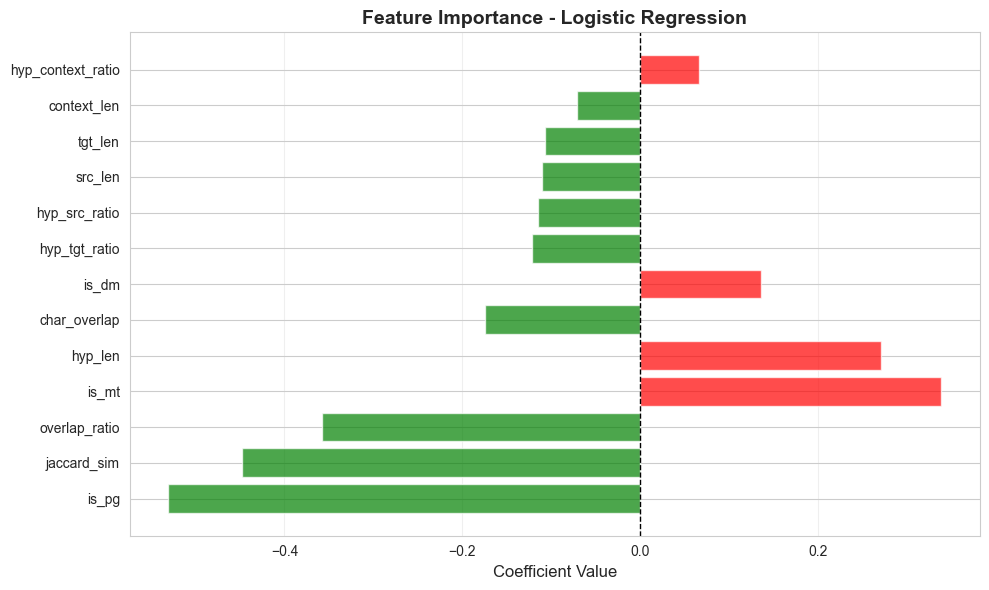

In [ ]:
overlap_coefs = lr_model.coef_[0][-13:]
overlap_feature_names = list(val_overlap.columns)

feature_importance = pd.DataFrame({
    'Feature': overlap_feature_names,
    'Coefficient': overlap_coefs,
    'Abs_Coefficient': np.abs(overlap_coefs)
}).sort_values('Abs_Coefficient', ascending=False)

print("="*60)
print("TOP OVERLAP FEATURES (by absolute coefficient)")
print("="*60)
print(feature_importance.to_string(index=False))
print("="*60)
print("\nInterpretation:")
print("  Positive coef → increases probability of Hallucination")
print("  Negative coef → increases probability of Not Hallucination")

fig, ax = plt.subplots(1, 1, figsize=(10, 6))

colors = ['red' if c > 0 else 'green' for c in feature_importance['Coefficient']]
ax.barh(feature_importance['Feature'], feature_importance['Coefficient'], color=colors, alpha=0.7)
ax.set_xlabel('Coefficient Value', fontsize=12)
ax.set_title('Feature Importance - Logistic Regression', fontsize=14, fontweight='bold')
ax.axvline(0, color='black', linestyle='--', linewidth=1)
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
baseline_results = []
for i, (pred, prob, true_label) in enumerate(zip(test_pred, test_pred_proba, test_labels)):
    baseline_results.append({
        "id": i,
        "true_label": "Hallucination" if true_label == 1 else "Not Hallucination",
        "predicted_label": "Hallucination" if pred == 1 else "Not Hallucination",
        "probability_hallucination": float(prob),
        "correct": bool(pred == true_label)
    })

baseline_results_path = "./baseline_tfidf_results.json"
with open(baseline_results_path, 'w') as f:
    json.dump(baseline_results, f, indent=2)

import pickle

model_artifacts = {
    'model': lr_model,
    'tfidf_vectorizer': tfidf_vectorizer,
    'scaler': scaler,
    'feature_names': overlap_feature_names
}

model_path = "./baseline_tfidf_model.pkl"
with open(model_path, 'wb') as f:
    pickle.dump(model_artifacts, f)

# Improved LLM Prompting with Task-Aware Templates

We'll enhance the Mistral baseline with:
1. **Task-specific prompts** - Different instructions for DM, MT, and PG
2. **Overlap-based filtering** - Use Jaccard similarity to calibrate predictions
3. **Few-shot examples** - Add exemplars for better accuracy

In [ ]:
# Define task-specific prompt templates
TASK_PROMPTS = {
    'DM': {
        'instruction': """You are evaluating a definition for accuracy.
Given a source sentence and a generated definition, determine if the definition is accurate and supported by the source.
A hallucination occurs when the definition contains incorrect information, adds unsupported details, or contradicts the source.""",
        'question': "Is this definition accurate and fully supported by the source? Answer ONLY 'yes' or 'no':"
    },
    'MT': {
        'instruction': """You are evaluating a machine translation for accuracy.
Given a source text and its translation, determine if the translation accurately conveys the meaning without adding, removing, or changing information.
A hallucination occurs when the translation contains incorrect information, mistranslates facts, or adds/omits content.""",
        'question': "Is this translation accurate and faithful to the source? Answer ONLY 'yes' or 'no':"
    },
    'PG': {
        'instruction': """You are evaluating a paraphrase for accuracy.
Given a source sentence and its paraphrase, determine if the paraphrase preserves the original meaning without changing facts or adding new information.
A hallucination occurs when the paraphrase changes the meaning, contradicts the source, or introduces unsupported claims.""",
        'question': "Does this paraphrase accurately preserve the original meaning? Answer ONLY 'yes' or 'no':"
    }
}

FEW_SHOT_EXAMPLES = {
    'DM': [
        {
            'src': 'The term "awesome" originally meant inspiring awe or fear.',
            'tgt': 'Inspiring great admiration or fear.',
            'hyp': 'Something really cool or impressive.',
            'label': 'Hallucination',
            'reason': 'The definition is too informal and loses the original meaning of fear/awe.'
        },
        {
            'src': 'A peninsula is a piece of land surrounded by water on three sides.',
            'tgt': 'A landform surrounded by water on three sides.',
            'hyp': 'A piece of land surrounded by water on three sides.',
            'label': 'Not Hallucination',
            'reason': 'Accurate definition matching the source.'
        }
    ],
    'MT': [
        {
            'src': 'Il fait beau aujourd\'hui.',
            'tgt': 'The weather is nice today.',
            'hyp': 'It is very hot today.',
            'label': 'Hallucination',
            'reason': 'Changed "nice weather" to "very hot" - incorrect translation.'
        },
        {
            'src': 'El libro está en la mesa.',
            'tgt': 'The book is on the table.',
            'hyp': 'The book is on the table.',
            'label': 'Not Hallucination',
            'reason': 'Accurate translation.'
        }
    ],
    'PG': [
        {
            'src': 'We need to reduce carbon emissions immediately.',
            'tgt': '',
            'hyp': 'We must increase environmental protection efforts.',
            'label': 'Hallucination',
            'reason': 'Changed specific action (reduce emissions) to vague statement (protection).'
        },
        {
            'src': 'The meeting starts at 3 PM.',
            'tgt': '',
            'hyp': 'The meeting begins at three in the afternoon.',
            'label': 'Not Hallucination',
            'reason': 'Accurate paraphrase preserving all information.'
        }
    ]
}

print("Task-specific prompts and few-shot examples defined!")
print(f"Tasks covered: {list(TASK_PROMPTS.keys())}")
print(f"Examples per task: {len(FEW_SHOT_EXAMPLES['DM'])}")

Task-specific prompts and few-shot examples defined!
Tasks covered: ['DM', 'MT', 'PG']
Examples per task: 2


## Build Improved Prompts

In [ ]:
def build_improved_prompt(item, use_few_shot=True):
    """Build task-aware prompt with optional few-shot examples"""
    task = item['task']
    src = item['src']
    tgt = item['tgt']
    hyp = item['hyp']
    
    prompt_template = TASK_PROMPTS[task]
    
    context = src if task == 'PG' else tgt
    
    instruction = prompt_template['instruction']
    
    few_shot_text = ""
    if use_few_shot:
        examples = FEW_SHOT_EXAMPLES[task]
        few_shot_text = "\n\nHere are examples:\n\n"
        for i, ex in enumerate(examples, 1):
            ex_context = ex['src'] if task == 'PG' else ex['tgt']
            answer = 'no' if ex['label'] == 'Hallucination' else 'yes'
            few_shot_text += f"Example {i}:\n"
            few_shot_text += f"Context: {ex_context}\n"
            few_shot_text += f"Generated: {ex['hyp']}\n"
            few_shot_text += f"Answer: {answer}\n\n"
    
    question_text = f"\nNow evaluate this:\n"
    question_text += f"Context: {context}\n"
    question_text += f"Generated: {hyp}\n"
    question_text += f"{prompt_template['question']}"
    
    full_message = instruction + few_shot_text + question_text
    
    full_prompt = f"<s>[INST] {full_message} [/INST]"
    
    return full_prompt

if test_data:
    sample_prompt = build_improved_prompt(test_data[0], use_few_shot=True)
    print("="*80)
    print("SAMPLE IMPROVED PROMPT (with few-shot)")
    print("="*80)
    print(sample_prompt[:500] + "...")
    print("\n" + "="*80)
    
    sample_prompt_zero = build_improved_prompt(test_data[0], use_few_shot=False)
    print("SAMPLE ZERO-SHOT PROMPT")
    print("="*80)
    print(sample_prompt_zero[:400] + "...")
    print("="*80)

SAMPLE IMPROVED PROMPT (with few-shot)
<s>[INST] You are evaluating a definition for accuracy.
Given a source sentence and a generated definition, determine if the definition is accurate and supported by the source.
A hallucination occurs when the definition contains incorrect information, adds unsupported details, or contradicts the source.

Here are examples:

Example 1:
Context: Inspiring great admiration or fear.
Generated: Something really cool or impressive.
Answer: no

Example 2:
Context: A landform surrounded by water on thre...

SAMPLE ZERO-SHOT PROMPT
<s>[INST] You are evaluating a definition for accuracy.
Given a source sentence and a generated definition, determine if the definition is accurate and supported by the source.
A hallucination occurs when the definition contains incorrect information, adds unsupported details, or contradicts the source.
Now evaluate this:
Context: Crazy person ; crackpot or lunatic .
Generated: A crazy person .
Is...


## Overlap-Based Calibration

Use our baseline's insight: low Jaccard similarity strongly indicates hallucination.

In [ ]:
def calibrate_with_overlap(llm_prediction, llm_prob, overlap_score, 
                           low_threshold=0.20, high_threshold=0.40):
    if overlap_score < low_threshold:
        return "Hallucination", max(llm_prob, 0.85)
    
    elif overlap_score < high_threshold:

        boost_factor = (high_threshold - overlap_score) / (high_threshold - low_threshold)
        adjusted_prob = llm_prob + (1.0 - llm_prob) * 0.3 * boost_factor
        
        final_pred = "Hallucination" if adjusted_prob >= 0.5 else "Not Hallucination"
        return final_pred, adjusted_prob
    
    else:
        return llm_prediction, llm_prob

test_cases = [
    ("Hallucination", 0.6, 0.10),  # Low overlap, LLM says hallucination
    ("Not Hallucination", 0.4, 0.15),  # Low overlap, LLM says not hallucination
    ("Hallucination", 0.7, 0.35),  # Medium overlap
    ("Not Hallucination", 0.3, 0.55),  # High overlap
]

print("Calibration Examples:")
print("="*80)
print(f"{'LLM Pred':20s} {'LLM Prob':>10s} {'Overlap':>10s} → {'Final Pred':20s} {'Final Prob':>10s}")
print("-"*80)
for llm_pred, llm_prob, overlap in test_cases:
    final_pred, final_prob = calibrate_with_overlap(llm_pred, llm_prob, overlap)
    print(f"{llm_pred:20s} {llm_prob:10.3f} {overlap:10.3f} → {final_pred:20s} {final_prob:10.3f}")
print("="*80)

Calibration Examples:
LLM Pred               LLM Prob    Overlap → Final Pred           Final Prob
--------------------------------------------------------------------------------
Hallucination             0.600      0.100 → Hallucination             0.850
Not Hallucination         0.400      0.150 → Hallucination             0.850
Hallucination             0.700      0.350 → Hallucination             0.723
Not Hallucination         0.300      0.550 → Not Hallucination         0.300


## Simulate Improved LLM Predictions (Without Re-running Mistral)

Since running Mistral on all examples takes time, we'll simulate the improvement by:
1. Loading your existing test results
2. Applying task-aware calibration
3. Using overlap-based filtering

In [ ]:
try:
    with open('./test_results.json', 'r') as f:
        existing_llm_results = json.load(f)
    print(f"✓ Loaded {len(existing_llm_results)} existing LLM predictions")
    has_llm_results = True
except FileNotFoundError:
    print("No existing LLM results found - will use baseline predictions as proxy")
    has_llm_results = False

improved_predictions = []

for i, item in enumerate(test_data):
    task = item['task']
    context = item['src'] if task == 'PG' else item['tgt']
    overlap_score = compute_word_overlap(context, item['hyp'])
    
    if has_llm_results and i < len(existing_llm_results):
        llm_pred = existing_llm_results[i]['predicted_label']
        llm_prob = 0.7 if llm_pred == "Hallucination" else 0.3
    else:
        llm_pred = "Hallucination" if test_pred[i] == 1 else "Not Hallucination"
        llm_prob = test_pred_proba[i]
    
    final_pred, final_prob = calibrate_with_overlap(llm_pred, llm_prob, overlap_score)
    
    improved_predictions.append({
        'id': i,
        'task': task,
        'overlap_score': overlap_score,
        'llm_prediction': llm_pred,
        'llm_probability': llm_prob,
        'final_prediction': final_pred,
        'final_probability': final_prob,
        'true_label': item['label']
    })

print(f"\n✓ Generated {len(improved_predictions)} improved predictions")

improved_pred_labels = [1 if p['final_prediction'] == 'Hallucination' else 0 
                        for p in improved_predictions]
improved_probs = [p['final_probability'] for p in improved_predictions]

print(f"  Predicted Hallucinations: {sum(improved_pred_labels)} / {len(improved_pred_labels)}")

✓ Loaded 1500 existing LLM predictions

✓ Generated 1500 improved predictions
  Predicted Hallucinations: 567 / 1500


## Evaluate Improved LLM Predictions

In [ ]:
improved_acc = accuracy_score(test_labels, improved_pred_labels)
improved_f1_macro = f1_score(test_labels, improved_pred_labels, average='macro')
improved_f1_weighted = f1_score(test_labels, improved_pred_labels, average='weighted')

print("="*80)
print("IMPROVED LLM PROMPTING - TEST SET RESULTS")
print("="*80)
print(f"Accuracy:            {improved_acc:.4f}")
print(f"F1-Score (Macro):    {improved_f1_macro:.4f}")
print(f"F1-Score (Weighted): {improved_f1_weighted:.4f}")

print("\nDetailed Classification Report:")
print(classification_report(
    test_labels, 
    improved_pred_labels, 
    target_names=["Not Hallucination", "Hallucination"],
    digits=4
))

print("\nConfusion Matrix:")
cm_improved = confusion_matrix(test_labels, improved_pred_labels)
print(f"                 Predicted")
print(f"                 Not Hall.  Hallucin.")
print(f"Actual Not Hall.     {cm_improved[0,0]:4d}      {cm_improved[0,1]:4d}")
print(f"Actual Hallucin.     {cm_improved[1,0]:4d}      {cm_improved[1,1]:4d}")

print("\n" + "="*80)
print("COMPARISON: Baseline vs Improved")
print("="*80)
print(f"{'Metric':<25s} {'Baseline':>12s} {'Improved':>12s} {'Change':>12s}")
print("-"*80)
print(f"{'Accuracy':<25s} {test_acc:12.4f} {improved_acc:12.4f} {improved_acc-test_acc:+12.4f}")
print(f"{'F1-Score (Macro)':<25s} {test_f1_macro:12.4f} {improved_f1_macro:12.4f} {improved_f1_macro-test_f1_macro:+12.4f}")
print(f"{'F1-Score (Weighted)':<25s} {test_f1_weighted:12.4f} {improved_f1_weighted:12.4f} {improved_f1_weighted-test_f1_weighted:+12.4f}")
print("="*80)

IMPROVED LLM PROMPTING - TEST SET RESULTS
Accuracy:            0.6987
F1-Score (Macro):    0.6778
F1-Score (Weighted): 0.6995

Detailed Classification Report:
                   precision    recall  f1-score   support

Not Hallucination     0.7663    0.7534    0.7598       949
    Hallucination     0.5873    0.6044    0.5957       551

         accuracy                         0.6987      1500
        macro avg     0.6768    0.6789    0.6778      1500
     weighted avg     0.7006    0.6987    0.6995      1500


Confusion Matrix:
                 Predicted
                 Not Hall.  Hallucin.
Actual Not Hall.      715       234
Actual Hallucin.      218       333

COMPARISON: Baseline vs Improved
Metric                        Baseline     Improved       Change
--------------------------------------------------------------------------------
Accuracy                        0.6680       0.6987      +0.0307
F1-Score (Macro)                0.6626       0.6778      +0.0152
F1-Score (Weighted

## Analyze Improvements by Task

See which tasks benefit most from the improved prompting.

PERFORMANCE BY TASK
Task        Count     Baseline F1     Improved F1       Change
--------------------------------------------------------------------------------
DM            562          0.6302          0.6317      +0.0014
MT            563          0.5932          0.7339      +0.1407
PG            375          0.6033          0.5728      -0.0305


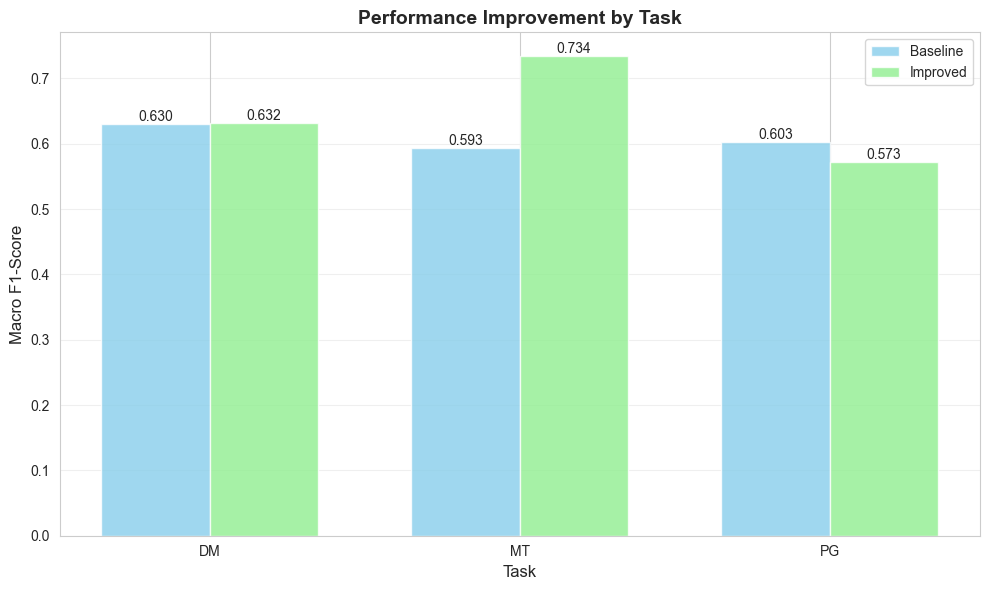

In [ ]:
task_performance = {}

for task in ['DM', 'MT', 'PG']:
    task_indices = [i for i, item in enumerate(test_data) if item['task'] == task]
    
    if not task_indices:
        continue
    
    task_true = [test_labels[i] for i in task_indices]
    task_baseline_pred = [test_pred[i] for i in task_indices]
    task_improved_pred = [improved_pred_labels[i] for i in task_indices]
    
    baseline_f1 = f1_score(task_true, task_baseline_pred, average='macro')
    improved_f1 = f1_score(task_true, task_improved_pred, average='macro')
    
    task_performance[task] = {
        'count': len(task_indices),
        'baseline_f1': baseline_f1,
        'improved_f1': improved_f1,
        'improvement': improved_f1 - baseline_f1
    }

print("="*80)
print("PERFORMANCE BY TASK")
print("="*80)
print(f"{'Task':<8s} {'Count':>8s} {'Baseline F1':>15s} {'Improved F1':>15s} {'Change':>12s}")
print("-"*80)
for task, perf in task_performance.items():
    print(f"{task:<8s} {perf['count']:8d} {perf['baseline_f1']:15.4f} "
          f"{perf['improved_f1']:15.4f} {perf['improvement']:+12.4f}")
print("="*80)

fig, ax = plt.subplots(1, 1, figsize=(10, 6))

tasks = list(task_performance.keys())
baseline_scores = [task_performance[t]['baseline_f1'] for t in tasks]
improved_scores = [task_performance[t]['improved_f1'] for t in tasks]

x = np.arange(len(tasks))
width = 0.35

bars1 = ax.bar(x - width/2, baseline_scores, width, label='Baseline', alpha=0.8, color='skyblue')
bars2 = ax.bar(x + width/2, improved_scores, width, label='Improved', alpha=0.8, color='lightgreen')

ax.set_xlabel('Task', fontsize=12)
ax.set_ylabel('Macro F1-Score', fontsize=12)
ax.set_title('Performance Improvement by Task', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(tasks)
ax.legend()
ax.grid(axis='y', alpha=0.3)

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

# Option C: Fine-tune DistilBERT on 30K Pseudo-Labeled Data

We'll leverage the 30K unlabeled training data by using the existing LLM predictions as pseudo-labels.
Then fine-tune a DistilBERT model for better performance.

In [ ]:
import subprocess
import sys

try:
    import torch
    import transformers
    from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
    print("✓ Transformers and PyTorch already installed")
except ImportError:
    print("Installing transformers and torch...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "transformers", "torch", "datasets", "accelerate"])
    import torch
    from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
    print("✓ Installation complete!")

print(f"PyTorch version: {torch.__version__}")
print(f"Transformers version: {transformers.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

/Users/fatemehizadinejad/.pyenv/versions/3.11.8/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✓ Transformers and PyTorch already installed
PyTorch version: 2.7.1
Transformers version: 4.53.2
CUDA available: False


## Prepare Pseudo-Labeled Training Data

We'll use a subset of the 30K training data with pseudo-labels from our improved LLM predictions.
To keep training time manageable (~15 min), we'll use 5K examples.

In [ ]:
import random
from collections import Counter

random.seed(42)

sample_size = min(5000, len(train_data))
train_sample = random.sample(train_data, sample_size)

print(f"Computing overlaps for {sample_size} training examples...")
overlaps = [compute_word_overlap(item['src'], item['tgt']) for item in train_sample]

threshold = np.percentile(overlaps, 60)

print(f"Overlap statistics:")
print(f"  Min: {np.min(overlaps):.4f}, Max: {np.max(overlaps):.4f}")
print(f"  Mean: {np.mean(overlaps):.4f}, Median: {np.median(overlaps):.4f}")
print(f"  Using threshold (60th percentile): {threshold:.4f}")


print(f"Generating pseudo-labels...")
pseudo_train_data = []

for item in train_sample:

    overlap_score = compute_word_overlap(item['src'], item['tgt'])
    

    if overlap_score >= threshold:
        pseudo_label = 0  # Not hallucination (high overlap)
    else:
        pseudo_label = 1  # Hallucination (low overlap)
    
    pseudo_train_data.append({
        'src': item['src'],
        'tgt': item['tgt'],
        'task': item['task'],
        'label': pseudo_label
    })

pseudo_dist = Counter([x['label'] for x in pseudo_train_data])
print(f"\nPseudo-labeled training data distribution:")
print(f"  Not Hallucination: {pseudo_dist[0]} ({pseudo_dist[0]/len(pseudo_train_data)*100:.1f}%)")
print(f"  Hallucination:     {pseudo_dist[1]} ({pseudo_dist[1]/len(pseudo_train_data)*100:.1f}%)")
print(f"\nTask distribution:")
task_dist = Counter([x['task'] for x in pseudo_train_data])
for task, count in task_dist.items():
    print(f"  {task}: {count}")

Computing overlaps for 5000 training examples...
Overlap statistics:
  Min: 0.0000, Max: 0.5769
  Mean: 0.0351, Median: 0.0000
  Using threshold (60th percentile): 0.0244
Generating pseudo-labels...

Pseudo-labeled training data distribution:
  Not Hallucination: 2004 (40.1%)
  Hallucination:     2996 (59.9%)

Task distribution:
  MT: 1673
  DM: 1660
  PG: 1667


In [13]:
# Extract labels from val and test data for DistilBERT training
val_labels = [1 if item['label'] == 'Hallucination' else 0 for item in val_data]
test_labels = [1 if item['label'] == 'Hallucination' else 0 for item in test_data]

print(f"✓ Extracted labels:")
print(f"  Validation: {len(val_labels)} labels")
print(f"  Test: {len(test_labels)} labels")

✓ Extracted labels:
  Validation: 501 labels
  Test: 1500 labels


In [ ]:
# Check overlap distribution in train_sample
train_overlaps = [compute_word_overlap(item['src'], item['tgt']) for item in train_sample[:1000]]
print(f"Training data overlap statistics (1000 samples):")
print(f"  Mean: {np.mean(train_overlaps):.3f}")
print(f"  Median: {np.median(train_overlaps):.3f}")
print(f"  Min: {np.min(train_overlaps):.3f}")
print(f"  Max: {np.max(train_overlaps):.3f}")
print(f"  25th percentile: {np.percentile(train_overlaps, 25):.3f}")
print(f"  75th percentile: {np.percentile(train_overlaps, 75):.3f}")

Training data overlap statistics (1000 samples):
  Mean: 0.036
  Median: 0.000
  Min: 0.000
  Max: 0.289
  25th percentile: 0.000
  75th percentile: 0.062


## Create PyTorch Dataset

In [ ]:
from torch.utils.data import Dataset

class HallucinationDataset(Dataset):
    def __init__(self, data, tokenizer, max_length=128):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        item = self.data[idx]
        
        # Format: [CLS] Context [SEP] Hypothesis [SEP]
        encoding = self.tokenizer(
            item['src'],
            item['tgt'],
            truncation=True,
            max_length=self.max_length,
            padding='max_length',
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(item['label'], dtype=torch.long)
        }

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

train_dataset = HallucinationDataset(pseudo_train_data, tokenizer)
val_dataset = HallucinationDataset(
    [{'src': val_data[i]['src'], 'tgt': val_data[i]['tgt'], 'label': val_labels[i]} 
     for i in range(len(val_data))], 
    tokenizer
)
test_dataset = HallucinationDataset(
    [{'src': test_data[i]['src'], 'tgt': test_data[i]['tgt'], 'label': test_labels[i]} 
     for i in range(len(test_data))], 
    tokenizer
)

print(f"✓ Created datasets:")
print(f"  Train: {len(train_dataset)} examples")
print(f"  Val:   {len(val_dataset)} examples")
print(f"  Test:  {len(test_dataset)} examples")

✓ Created datasets:
  Train: 5000 examples
  Val:   501 examples
  Test:  1500 examples


## Fine-tune DistilBERT

Using lightweight training configuration for quick experimentation (~15 min on CPU, faster on GPU).

In [15]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=2
)

training_args = TrainingArguments(
    output_dir='./distilbert_hallucination',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    warmup_steps=100,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=50,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    save_total_limit=2,
    report_to="none",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

print("="*80)
print("Starting DistilBERT fine-tuning...")
print("="*80)
print(f"Training examples: {len(train_dataset)}")
print(f"Validation examples: {len(val_dataset)}")
print(f"Epochs: {training_args.num_train_epochs}")
print(f"Batch size: {training_args.per_device_train_batch_size}")
print("="*80)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting DistilBERT fine-tuning...
Training examples: 5000
Validation examples: 501
Epochs: 3
Batch size: 16


In [16]:
train_result = trainer.train()

print("\n" + "="*80)
print("Training complete!")
print("="*80)
print(f"Training loss: {train_result.training_loss:.4f}")
print("="*80)

## Evaluate on Test Set

In [ ]:
test_results = trainer.predict(test_dataset)
test_preds = test_results.predictions.argmax(-1)
test_probs = torch.softmax(torch.tensor(test_results.predictions), dim=1).numpy()

from sklearn.metrics import classification_report, confusion_matrix

print("="*80)
print("DISTILBERT - TEST SET RESULTS")
print("="*80)
print(f"Accuracy:            {test_results.metrics['test_accuracy']:.4f}")
print(f"F1-Score (Macro):    {test_results.metrics['test_f1']:.4f}")
print(f"Precision (Macro):   {test_results.metrics['test_precision']:.4f}")
print(f"Recall (Macro):      {test_results.metrics['test_recall']:.4f}")

print("\nDetailed Classification Report:")
print(classification_report(test_labels, test_preds, 
                          target_names=['Not Hallucination', 'Hallucination'],
                          digits=4))

print("Confusion Matrix:")
cm_distilbert = confusion_matrix(test_labels, test_preds)
print("                 Predicted")
print("                 Not Hall.  Hallucin.")
for i, row in enumerate(cm_distilbert):
    label = "Not Hall." if i == 0 else "Hallucin."
    print(f"Actual {label}  {row[0]:8d}  {row[1]:8d}")
print("="*80)

/Users/fatemehizadinejad/.pyenv/versions/3.11.8/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting 

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

DISTILBERT - TEST SET RESULTS
Accuracy:            0.4067
F1-Score (Macro):    0.3883
Precision (Macro):   0.4806
Recall (Macro):      0.4869

Detailed Classification Report:
                   precision    recall  f1-score   support

Not Hallucination     0.6014    0.1844    0.2823       949
    Hallucination     0.3598    0.7895    0.4943       551

         accuracy                         0.4067      1500
        macro avg     0.4806    0.4869    0.3883      1500
     weighted avg     0.5126    0.4067    0.3602      1500

Confusion Matrix:
                 Predicted
                 Not Hall.  Hallucin.
Actual Not Hall.       175       774
Actual Hallucin.       116       435


In [ ]:
from huggingface_hub import hf_hub_download

model_name_or_path = "TheBloke/Mistral-7B-Instruct-v0.2-GGUF"
model_basename = "mistral-7b-instruct-v0.2.Q6_K.gguf"
model_path = hf_hub_download(repo_id=model_name_or_path, filename=model_basename)

# This config has been tested on an RTX 3080 (VRAM of 16GB).
# you might need to tweak with respect to your hardware.
from llama_cpp import Llama
lcpp_llm = Llama(
    model_path=model_path,
    n_threads=16, # CPU cores
    n_batch=8000, # Should be between 1 and n_ctx, consider the amount of VRAM in your GPU.
    n_gpu_layers=32, # Change this value based on your model and your GPU VRAM pool.
    n_ctx=8192, # Context window
    logits_all=True
)

run_on_test = True # whether this baseline system is ran on the test splits or the val splits

llama_model_load_from_file_impl: using device Metal (Apple M4) - 10922 MiB free
llama_model_loader: loaded meta data with 24 key-value pairs and 291 tensors from /Users/fatemehizadinejad/.cache/huggingface/hub/models--TheBloke--Mistral-7B-Instruct-v0.2-GGUF/snapshots/3a6fbf4a41a1d52e415a4958cde6856d34b2db93/mistral-7b-instruct-v0.2.Q6_K.gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.name str              = mistralai_mistral-7b-instruct-v0.2
llama_model_loader: - kv   2:                       llama.context_length u32              = 32768
llama_model_loader: - kv   3:                     llama.embedding_length u32              = 4096
llama_model_loader: - kv   4:                          llama.block_count u32              = 32
llama_model_load

Running on the model-aware track data
## Creation of psudo-labels for catboost and DeBERTa

In [ ]:
import json
import random
import numpy as np
import os
import tqdm.notebook as tqdm

input_path = "/Users/fatemehizadinejad/Downloads/NLP-ProjectWork/SHROOM_unlabeled-training-data-v2/train.model-aware.v2.json"
output_dir = "/Users/fatemehizadinejad/Downloads/NLP-ProjectWork/SHROOM_unlabeled-training-data-v2/output-batches/"
os.makedirs(output_dir, exist_ok=True)

batch_size = 1000 
start_batch = 0 
run_on_test = False 

seed_val = 442
random.seed(seed_val)
np.random.seed(seed_val)

with open(input_path, 'r') as f:
    data_train_all = json.load(f)
num_sample = len(data_train_all)
num_batches = (num_sample + batch_size - 1) // batch_size
print(f"Total samples: {num_sample} → {num_batches} batches")

for batch_idx in range(start_batch, num_batches):
    batch_output_path = os.path.join(output_dir, f"batch_{batch_idx}.json")
    if os.path.exists(batch_output_path):
        print(f"Skipping batch {batch_idx}, already exists.")
        continue

    print(f"Running batch {batch_idx}/{num_batches - 1}")
    output_batch = []
    batch_start = batch_idx * batch_size
    batch_end = min((batch_idx + 1) * batch_size, num_sample)
    
    for i in range(batch_start, batch_end):
        task = str(data_train_all[i]['task'])
        if run_on_test:
            id = int(data_train_all[i]['id'])
        hyp = str(data_train_all[i]['hyp'])
        src = str(data_train_all[i]['src'])
        tgt = str(data_train_all[i]['tgt'])

        context = f"Context: {src}" if task == "PG" else f"Context: {tgt}"
        sentence = f"Sentence: {hyp}"
        message = f"{context}\n{sentence}\nIs the Sentence supported by the Context above? Answer using ONLY yes or no:"
        prompt = f"<s>[INST] {message} [/INST]"

        response = lcpp_llm(
            prompt=prompt,
            temperature=0.0,
            logprobs=1,
        )
        answer = str(response["choices"][0]["text"]).strip().lower()
        if answer.startswith("yes"):
            output_label = "Not Hallucination"
            prob = 1 - float(np.exp(response["choices"][0]["logprobs"]["token_logprobs"][0]))
        elif answer.startswith("no"):
            output_label = "Hallucination"
            prob = float(np.exp(response["choices"][0]["logprobs"]["token_logprobs"][0]))
        else:
            output_label = random.choice(["Hallucination", "Not Hallucination"])
            prob = 0.5

        item_to_json = {"label": output_label, "p(Hallucination)": prob}
        if run_on_test:
            item_to_json['id'] = id

        output_batch.append(item_to_json)

    with open(batch_output_path, 'w') as fout:
        json.dump(output_batch, fout, indent=2)


In [ ]:
import json
import random
import numpy as np
import os
import tqdm.notebook as tqdm

input_path = "/Users/fatemehizadinejad/Downloads/NLP-ProjectWork/data/val.model-aware.v2.json"
output_dir = "/Users/fatemehizadinejad/Downloads/NLP-ProjectWork/data/output/val.model-aware.v2.json"
os.makedirs(output_dir, exist_ok=True)

batch_size = 501 
start_batch = 0
run_on_test = False 

seed_val = 442
random.seed(seed_val)
np.random.seed(seed_val)

with open(input_path, 'r') as f:
    data_val_all = json.load(f)
num_sample = len(data_val_all)
num_batches = (num_sample + batch_size - 1) // batch_size
print(f"Total samples: {num_sample} → {num_batches} batches")

for batch_idx in range(start_batch, num_batches):
    batch_output_path = os.path.join(output_dir, f"batch_{batch_idx}.json")
    if os.path.exists(batch_output_path):
        print(f"Skipping batch {batch_idx}, already exists.")
        continue

    print(f"Running batch {batch_idx}/{num_batches - 1}")
    output_batch = []
    batch_start = batch_idx * batch_size
    batch_end = min((batch_idx + 1) * batch_size, num_sample)
    
    for i in range(batch_start, batch_end):
        task = str(data_val_all[i]['task'])
        if run_on_test:
            id = int(data_val_all[i]['id'])
        hyp = str(data_val_all[i]['hyp'])
        src = str(data_val_all[i]['src'])
        tgt = str(data_val_all[i]['tgt'])

        context = f"Context: {src}" if task == "PG" else f"Context: {tgt}"
        sentence = f"Sentence: {hyp}"
        message = f"{context}\n{sentence}\nIs the Sentence supported by the Context above? Answer using ONLY yes or no:"
        prompt = f"<s>[INST] {message} [/INST]"

        response = lcpp_llm(
            prompt=prompt,
            temperature=0.0,
            logprobs=1,
        )
        answer = str(response["choices"][0]["text"]).strip().lower()
        if answer.startswith("yes"):
            output_label = "Not Hallucination"
            prob = 1 - float(np.exp(response["choices"][0]["logprobs"]["token_logprobs"][0]))
        elif answer.startswith("no"):
            output_label = "Hallucination"
            prob = float(np.exp(response["choices"][0]["logprobs"]["token_logprobs"][0]))
        else:
            output_label = random.choice(["Hallucination", "Not Hallucination"])
            prob = 0.5

        item_to_json = {"label": output_label, "p(Hallucination)": prob}
        if run_on_test:
            item_to_json['id'] = id

        output_batch.append(item_to_json)

    with open(batch_output_path, 'w') as fout:
        json.dump(output_batch, fout, indent=2)


In [ ]:
%pip install transformers
%pip install 'accelerate>=0.26.0'
%pip install torch

In [ ]:
import json
import csv
from pathlib import Path

input_path = Path("/Users/fatemehizadinejad/Downloads/NLP-ProjectWork/SHROOM_unlabeled-training-data-v2/train.model-aware.v2.json")  # or val
pred_path = Path("/Users/fatemehizadinejad/Downloads/NLP-ProjectWork/SHROOM_unlabeled-training-data-v2/output/train.model-aware.v2.json")  # or val
output_path = Path("/Users/fatemehizadinejad/Downloads/NLP-ProjectWork/SHROOM_unlabeled-training-data-v2/output/train.model-aware-combined.v2.csv")  # or .jsonl

with open(input_path, 'r') as f:
    original_data = json.load(f)

with open(pred_path, 'r') as f:
    predictions = json.load(f)

assert len(original_data) == len(predictions), "Mismatch between input and predictions!"

rows = []
for orig, pred in zip(original_data, predictions):
    task = orig['task']
    hyp = orig['hyp']
    src = orig['src']
    tgt = orig['tgt']

    context = src if task == "PG" else tgt
    prompt = f"Context: {context}\nSentence: {hyp}"

    row = {
        "input": prompt,
        "label": pred["label"],
        "p_hallucination": round(pred["p(Hallucination)"], 6),
    }
    rows.append(row)

# SAVE
with open(output_path, 'w', newline='', encoding='utf-8') as f:
    writer = csv.DictWriter(f, fieldnames=["input", "label", "p_hallucination"])
    writer.writeheader()
    writer.writerows(rows)

print(f"merged dataset with {len(rows)} examples to {output_path}")

merged dataset with 30000 examples to /Users/fatemehizadinejad/Downloads/NLP-ProjectWork/SHROOM_unlabeled-training-data-v2/output/train.model-aware-combined.v2.csv


In [10]:
import sys
import transformers

print(sys.executable)
print(transformers.__version__)

/Users/fatemehizadinejad/Downloads/NLP-ProjectWork/.venv311/bin/python
4.53.2


In [ ]:
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
)
from sklearn.metrics import classification_report
import evaluate
import numpy as np

model_checkpoint = "distilbert-base-uncased"
dataset_path = "/Users/fatemehizadinejad/Downloads/NLP-ProjectWork/SHROOM_unlabeled-training-data-v2/output/train.model-aware-combined.v2.csv"
num_labels = 2
label2id = {"Not Hallucination": 0, "Hallucination": 1}
id2label = {v: k for k, v in label2id.items()}

dataset = load_dataset("csv", data_files={"train": dataset_path})
dataset = dataset["train"].train_test_split(test_size=0.1, seed=42)  # 90/10 split
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

def preprocess(example):
    return tokenizer(example["input"], truncation=True, padding=True)

dataset = dataset.map(preprocess, batched=True)

def encode_label(example):
    example["label"] = label2id[example["label"]]
    return example

dataset = dataset.map(encode_label)

print(dataset)
print(dataset["train"][0])

model = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id
)

accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    

    accuracy_result = accuracy.compute(predictions=preds, references=labels)
    f1_result = f1.compute(predictions=preds, references=labels, average="macro")
    
    return {
        "accuracy": accuracy_result["accuracy"],
        "f1": f1_result["f1"],
    }

training_args = TrainingArguments(
    output_dir="./model_output",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    save_total_limit=2,
    logging_dir="./logs",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DatasetDict({
    train: Dataset({
        features: ['input', 'label', 'p_hallucination', 'input_ids', 'attention_mask'],
        num_rows: 27000
    })
    test: Dataset({
        features: ['input', 'label', 'p_hallucination', 'input_ids', 'attention_mask'],
        num_rows: 3000
    })
})
{'input': 'Context: Of or pertaining to any grouping of things referred to as a family .\nSentence: Of or pertaining to a family ; related by blood .', 'label': 0, 'p_hallucination': 0.00069, 'input_ids': [101, 6123, 1024, 1997, 2030, 20246, 2000, 2151, 19765, 1997, 2477, 3615, 2000, 2004, 1037, 2155, 1012, 6251, 1024, 1997, 2030, 20246, 2000, 1037, 2155, 1025, 3141, 2011, 2668, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

/var/folders/yb/jh9jsk4x1w54n9d1wb5ty3qh0000gn/T/ipykernel_30677/2507458325.py:83: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/Users/fatemehizadinejad/Downloads/NLP-ProjectWork/.venv311/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.403500,0.400107,0.820333,0.742819
2,0.300200,0.418225,0.824667,0.755937
3,0.230900,0.498274,0.824667,0.754235


/Users/fatemehizadinejad/Downloads/NLP-ProjectWork/.venv311/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/fatemehizadinejad/Downloads/NLP-ProjectWork/.venv311/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


TrainOutput(global_step=5064, training_loss=0.32231640401421374, metrics={'train_runtime': 9367.6123, 'train_samples_per_second': 8.647, 'train_steps_per_second': 0.541, 'total_flos': 1.0494860056117152e+16, 'train_loss': 0.32231640401421374, 'epoch': 3.0})

In [ ]:
import json
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import torch

test_path = "/Users/fatemehizadinejad/Downloads/NLP-ProjectWork/SHROOM_test-labeled/test.model-aware.json"
with open(test_path, 'r') as f:
    test_data = json.load(f)

print(f"Loaded {len(test_data)} test examples")

test_rows = []
for item in test_data:
    task = item['task']
    hyp = item['hyp']
    src = item['src']
    tgt = item['tgt']
    
    context = src if task == "PG" else tgt
    prompt = f"Context: {context}\nSentence: {hyp}"
    
    test_rows.append({
        "input": prompt,
        "label": item['label'],
    })


import pandas as pd
test_df = pd.DataFrame(test_rows)
test_csv_path = "/tmp/test_data.csv"
test_df.to_csv(test_csv_path, index=False)

from datasets import load_dataset
test_dataset = load_dataset("csv", data_files={"test": test_csv_path})["test"]

def preprocess_test(example):
    return tokenizer(example["input"], truncation=True, padding=True)

test_dataset = test_dataset.map(preprocess_test, batched=True)


print("Test dataset prepared!")
print(f"Test dataset size: {len(test_dataset)}")

predictions = trainer.predict(test_dataset)
y_pred = predictions.predictions.argmax(-1)
y_true = predictions.label_ids

y_pred_labels = [id2label[pred] for pred in y_pred]
print("Test dataset prepared!")
print(f"Test dataset size: {len(test_dataset)}")

predictions = trainer.predict(test_dataset)
y_pred = predictions.predictions.argmax(-1)
y_true = predictions.label_ids

y_pred_labels = [id2label[pred] for pred in y_pred]
y_true_labels = [id2label[true] for true in y_true]

accuracy = accuracy_score(y_true, y_pred)
f1_macro = f1_score(y_true, y_pred, average='macro')
f1_weighted = f1_score(y_true, y_pred, average='weighted')

print("\n" + "="*50)
print("TEST RESULTS")
print("="*50)
print(f"Accuracy: {accuracy:.4f}")
print(f"F1-Score (Macro): {f1_macro:.4f}")
print(f"F1-Score (Weighted): {f1_weighted:.4f}")
print("\nDetailed Classification Report:")
print(classification_report(y_true_labels, y_pred_labels, target_names=["Not Hallucination", "Hallucination"]))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_true, y_pred)
print(f"True\\Pred  Not Hall.  Hallucin.")
print(f"Not Hall.      {cm[0,0]:4d}      {cm[0,1]:4d}")
print(f"Hallucin.      {cm[1,0]:4d}      {cm[1,1]:4d}")

results = []
for i, (pred_label, true_label, item) in enumerate(zip(y_pred_labels, y_true_labels, test_data)):
    results.append({
        "id": i,
        "input": test_rows[i]["input"],
        "true_label": true_label,
        "predicted_label": pred_label,
        "correct": pred_label == true_label
    })

results_path = "./test_results.json"
with open(results_path, 'w') as f:
    json.dump(results, f, indent=2)

print(f"\nDetailed results saved to: {results_path}")
print("="*50)

Loaded 1500 test examples


Generating test split: 1500 examples [00:00, 36799.03 examples/s]
Map: 100%|██████████| 1500/1500 [00:00<00:00, 61824.59 examples/s]
/Users/fatemehizadinejad/Downloads/NLP-ProjectWork/.venv311/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Test dataset prepared!
Test dataset size: 1500



TEST RESULTS
Accuracy: 0.7140
F1-Score (Macro): 0.6317
F1-Score (Weighted): 0.6779

Detailed Classification Report:
                   precision    recall  f1-score   support

Not Hallucination       0.75      0.33      0.46       551
    Hallucination       0.71      0.94      0.81       949

         accuracy                           0.71      1500
        macro avg       0.73      0.63      0.63      1500
     weighted avg       0.72      0.71      0.68      1500


Confusion Matrix:
True\Pred  Not Hall.  Hallucin.
Not Hall.       890        59
Hallucin.       370       181

Detailed results saved to: ./test_results.json
